<a href="https://www.kaggle.com/code/aleksandrmorozov123/time-series-forecasting?scriptVersionId=158940805" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gold-price-prediction-dataset/FINAL_USO.csv


**Create distribution and log-transform it** - each value $x$ gets replaced by $ \log (x) $

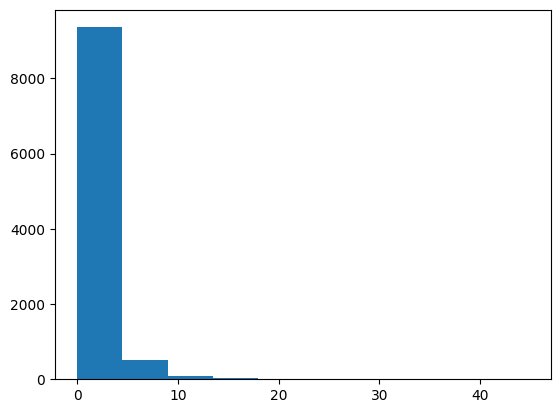

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed (0)
pts = 10000
vals = np.random.lognormal (0, 1.0, pts)

plt.hist(vals)

plt.show()

**Apply the standard normalization to z-scores** 

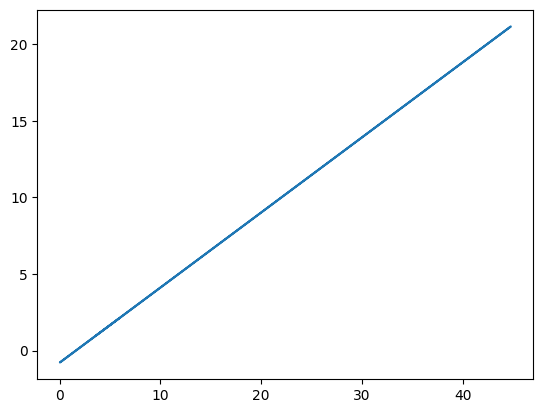

In [3]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest

scaler = StandardScaler ()
vals_ss = scaler.fit_transform (vals.reshape (-1, 1))
_, p = normaltest (vals_ss)

plt.plot(vals,vals_ss) 
plt.show()

# **Apply the minmax transformation** - $ x' = b \frac {a + x - \min (x)}{\max(x) - \min (x)}$

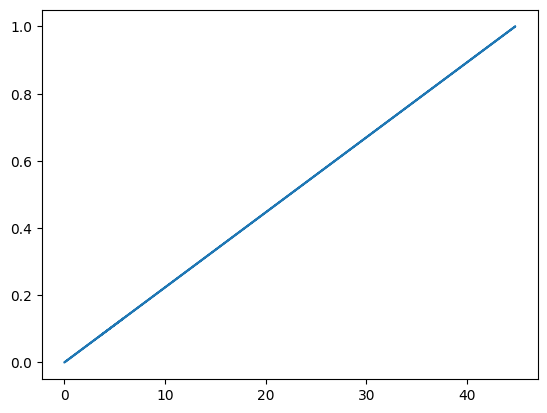

In [4]:
from sklearn.preprocessing import minmax_scale

vals_mm = minmax_scale (vals)
_, p = normaltest (vals_mm.squeeze ())

plt.plot(vals,vals_mm) 
plt.show()

**Use a log transformation**

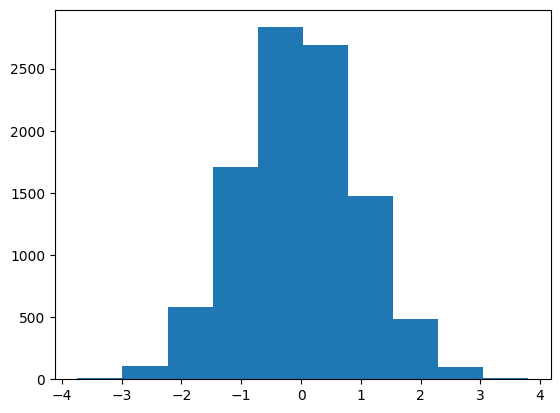

In [5]:
log_transformed = np.log (vals)
_, p = normaltest (log_transformed)

plt.hist(log_transformed)
plt.show()

**Apply Box-Cox transformation** - 
$x_{i}^{(\lambda)}=\frac{x_i^{\lambda} - 1}{\lambda}$ if $\lambda \neq 0$ and
$x_{i}^{(\lambda)} =\ln x_i$ if $\lambda = 0$

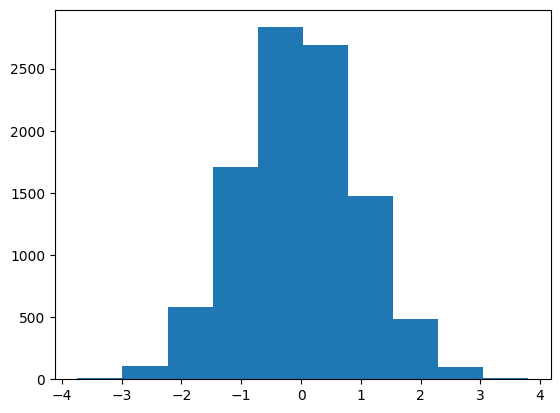

In [6]:
from scipy.stats import boxcox
vals_bs = boxcox (vals, 0.0)

plt.hist(vals_bs)
plt.show()

**Generating synthetic white noise**

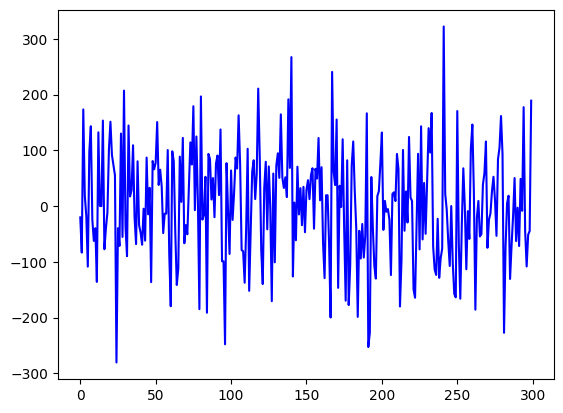

In [7]:
time = np.arange (300)
values = np.random.randn (300) * 100

fig, ax = plt.subplots()

ax.plot(time, values, color="blue")

# **Red noise** - $ x_{j+1} = r \cdot x_j + (1 - r^2)^{\frac{1}{2}} \cdot w$

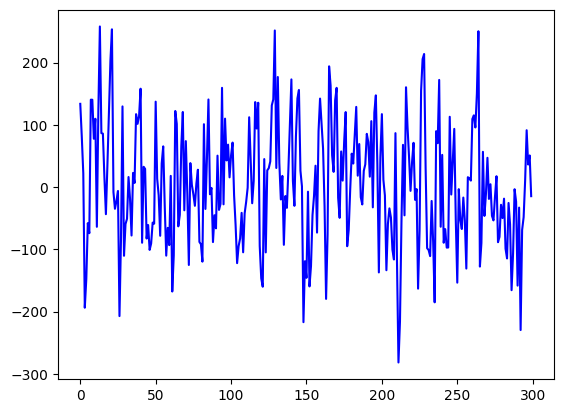

In [8]:
r = 0.4
time = np.arange (300)
white_noise = np.random.randn (300) * 100
values = np.zeros (300)

for i, v in enumerate (white_noise):
    if i == 0:
        values [i] = v
    else:
        values [i] = r*values [i-1] + np.sqrt ((1-np.power (r, 2))) * v

fig, ax = plt.subplots()

ax.plot(time, values, color="blue")

**Create synthetical cyclical time series**

  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-84tzrkkn
  Running command git clone --filter=blob:none --quiet https://github.com/TimeSynth/TimeSynth.git /tmp/pip-req-build-84tzrkkn
  Resolved https://github.com/TimeSynth/TimeSynth.git to commit e50cdb9015d415adf46a4eae161a087c5c378564
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for symengine>=0.4 from https://files.pythonhosted.org/packages/a6/69/97a99ae1835810e0f3f4f471cdfcb6d886be93e4ee5688397deacab955bc/symengine-0.11.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 38.7 MB/s eta 0:00:00
  Created wheel for timesynth: filename=timesynth-0.2.4-py3-none-any.whl size=15422 sha256=0456f85bc9b4b3be312bc2ba0f606783

Text(0.5, 1.0, 'Irregularly sampled sinusoid with noise')

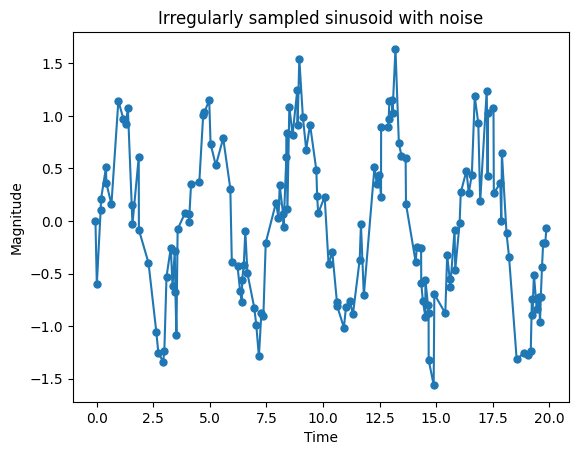

In [9]:
# cite from -  J. R. Maat, A. Malali, and P. Protopapas, 
#“TimeSynth: A Multipurpose Library for Synthetic Time Series in Python,” 2017. 
#[Online]. Available: http://github.com/TimeSynth/TimeSynth
!pip uninstall timesynth --yes
!pip install git+https://github.com/TimeSynth/TimeSynth.git
import timesynth as ts

time_sampler = ts.TimeSampler (stop_time = 20)
irregular_time_samples = time_sampler.sample_irregular_time (num_points = 300,
                                                            keep_percentage = 50)
sinusoid = ts.signals.Sinusoidal (frequency = 0.25)
white_noise = ts.noise.GaussianNoise (std = 0.3)
timeseries = ts.TimeSeries (sinusoid, noise_generator = white_noise)
samples, signals, errors = timeseries.sample (irregular_time_samples)

plt.plot (irregular_time_samples, samples, marker = "o", markersize = 5)
plt.xlabel ("Time")
plt.ylabel ("Magnitude")
plt.title ("Irregularly sampled sinusoid with noise")

**Create autoregressive signals with parameters 0.9 and 0.01**

Text(0.5, 1.0, 'Example Continuous Autoregressive process')

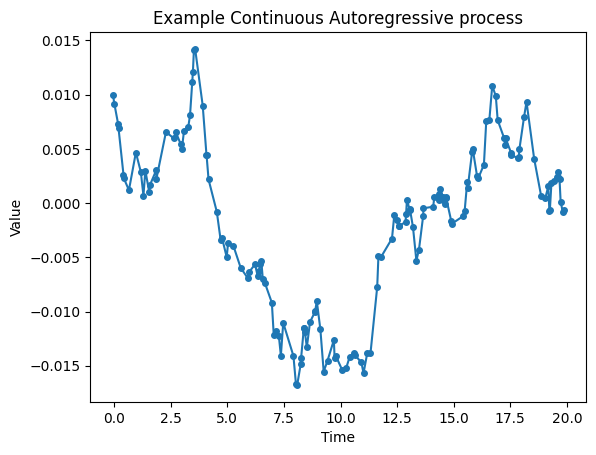

In [10]:
car = ts.signals.CAR (ar_param = 0.8, sigma = 0.01)
car_series = ts.TimeSeries (signal_generator = car)
samples = car_series.sample (irregular_time_samples)

plt.plot (irregular_time_samples, samples[0], marker = 'o', markersize = 4)
plt.xlabel ('Time')
plt.ylabel ('Value')
plt.title ('Example Continuous Autoregressive process')

**Gaussian Process signals with Matern 3/2-kernel** $k(x, y) = \sigma^2 (1 + \frac {\sqrt{3} |x-y|}{\theta}) \exp (- \frac{\sqrt{3} |x - y|}{\theta})$ 


Text(0.5, 1.0, 'Gaussian Process signal with Matern 3/2-kernel')

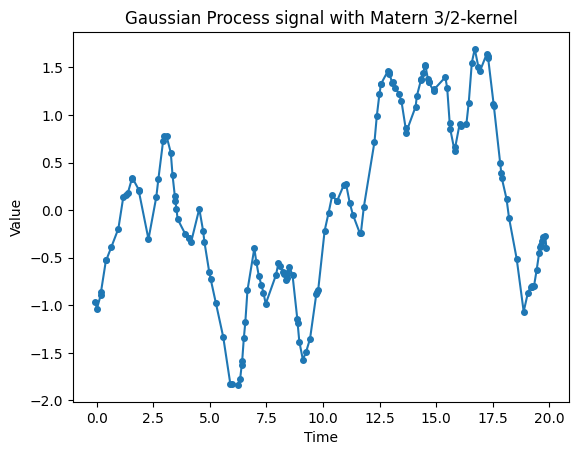

In [11]:
gp = ts.signals.GaussianProcess (kernel = 'Matern', nu = 3./2)
gp_series = ts.TimeSeries (signal_generator = gp)
samples = gp_series.sample (irregular_time_samples)[0]

plt.plot (irregular_time_samples, samples, marker = 'o', markersize = 4)
plt.xlabel ('Time')
plt.ylabel ('Value')
plt.title ('Gaussian Process signal with Matern 3/2-kernel')

**Generating Pseudo Periodic Signal**

Text(0.5, 1.0, 'Pseudoperiodic signal')

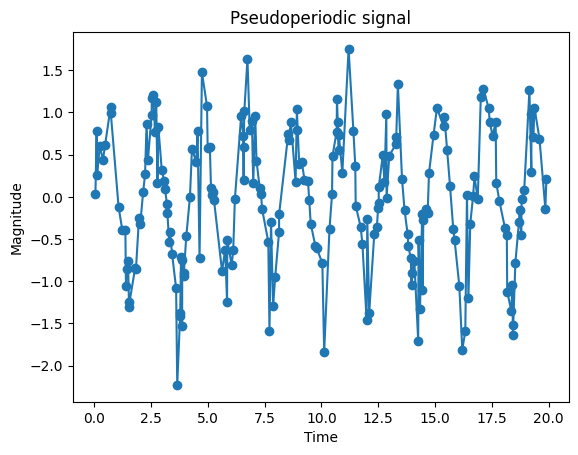

In [12]:
time_sampler_pp = ts.TimeSampler (stop_time = 20)
irregular_time_samples_pp = time_sampler_pp.sample_irregular_time (resolution = 0.05, keep_percentage = 50)

pseudo_periodic = ts.signals.PseudoPeriodic (frequency = 3, freqSD = 0.01, ampSD = 0.5)

timeseries_pp = ts.TimeSeries (pseudo_periodic)
samples_pp , signals_pp, errors_pp = timeseries_pp.sample (irregular_time_samples_pp)

plt.plot (irregular_time_samples_pp, samples_pp, marker = 'o')
plt.xlabel ('Time')
plt.ylabel ('Magnitude')
plt.title ('Pseudoperiodic signal')

**The random walk process**

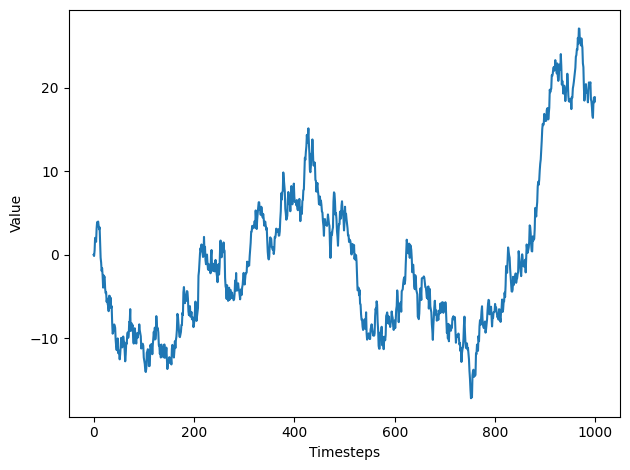

In [13]:
np.random.seed (42)
steps = np.random.standard_normal (1000)
steps [0] = 0
random_walk = np.cumsum (steps)

fig, ax = plt.subplots ()
ax.plot (random_walk)
ax.set_xlabel ('Timesteps')
ax.set_ylabel ('Value')

plt.tight_layout ()

**Testing for stationarity**

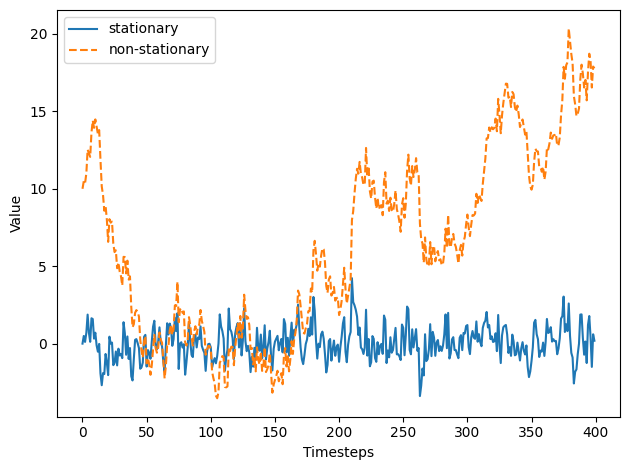

In [14]:
def simulate_process (is_stationary: bool) -> np.array:
    np.random.seed (42)
    process = np.empty (400)
    
    if is_stationary:
        alpha = 0.5
        process [0] = 0
    else:
        alpha = 1
        process [0] = 10
        
    for i in range (400):
        if i+1 < 400:
            process [i+1] = alpha*process[i] + np.random.standard_normal ()
        else:
            break
            
    return process

stationary = simulate_process (True)
non_stationary = simulate_process (False)

fig, ax = plt.subplots ()
ax.plot (stationary, linestyle = "-", label = 'stationary')
ax.plot (non_stationary, linestyle = '--', label = 'non-stationary')
ax.set_xlabel ("Timesteps")
ax.set_ylabel ('Value')
ax.legend (loc=2)

plt.tight_layout ()

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


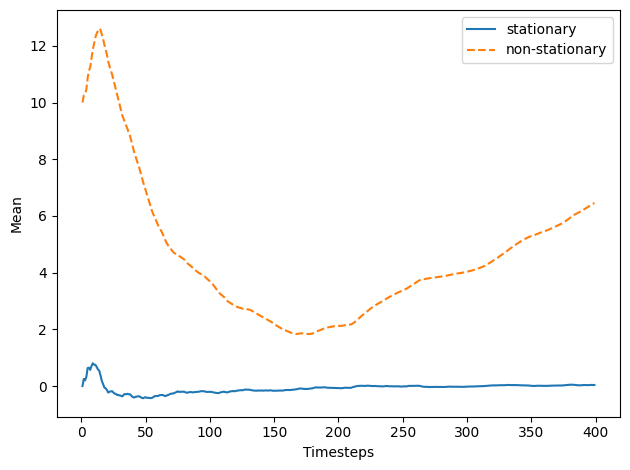

In [15]:
def mean_over_time (process: np.array) -> np.array:
    mean_func = []
    
    for i in range (len (process)):
        mean_func.append (np.mean (process [:i]))
        
    return mean_func

stationary_mean = mean_over_time (stationary)
non_stationary_mean = mean_over_time (non_stationary)

fig, ax = plt.subplots ()
ax.plot (stationary_mean, label = 'stationary')
ax.plot (non_stationary_mean, linestyle = '--', label = 'non-stationary')
ax.set_xlabel ('Timesteps')
ax.set_ylabel ('Mean')
ax.legend (loc=1)

plt.tight_layout ()

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


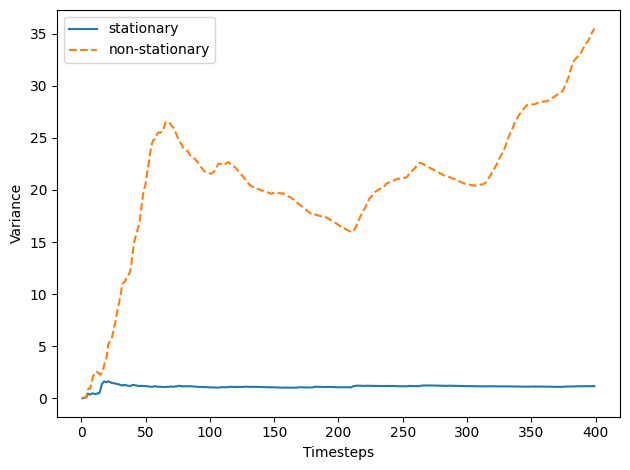

In [16]:
def var_over_time (process: np.array) -> np.array:
    var_func = []
    
    for i in range (len(process)):
        var_func.append (np.var (process [:i]))
        
    return var_func

stationary_var = var_over_time (stationary)
non_stationary_var = var_over_time (non_stationary)

fig, ax = plt.subplots ()
ax.plot (stationary_var, label = 'stationary')
ax.plot (non_stationary_var, linestyle = '--', label = 'non-stationary')
ax.set_xlabel ('Timesteps')
ax.set_ylabel ('Variance')
ax.legend (loc = 2)

plt.tight_layout ()

**Create the model**

In [17]:
df = pd.read_csv ('/kaggle/input/gold-price-prediction-dataset/FINAL_USO.csv')
df.head ()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [18]:
df.tail ()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
1713,2018-12-24,119.570000,120.139999,119.570000,120.019997,120.019997,9736400,239.039993,240.839996,234.270004,...,20.650000,21.090000,21.090000,60507000,9.49,9.52,9.28,9.29,9.29,21598200
1714,2018-12-26,120.620003,121.000000,119.570000,119.660004,119.660004,14293500,235.970001,246.179993,233.759995,...,20.530001,20.620001,20.620001,76365200,9.25,9.92,9.23,9.90,9.90,40978800
1715,2018-12-27,120.570000,120.900002,120.139999,120.570000,120.570000,11874400,242.570007,248.289993,238.960007,...,20.700001,20.969999,20.969999,52393000,9.59,9.65,9.37,9.62,9.62,36578700
1716,2018-12-28,120.800003,121.080002,120.720001,121.059998,121.059998,6864700,249.580002,251.399994,246.449997,...,20.570000,20.600000,20.600000,49835000,9.54,9.65,9.38,9.53,9.53,22803400
1717,2018-12-31,120.980003,121.260002,120.830002,121.250000,121.250000,8449400,249.559998,250.190002,247.470001,...,20.559999,21.090000,21.090000,53866600,9.63,9.71,9.44,9.66,9.66,28417400


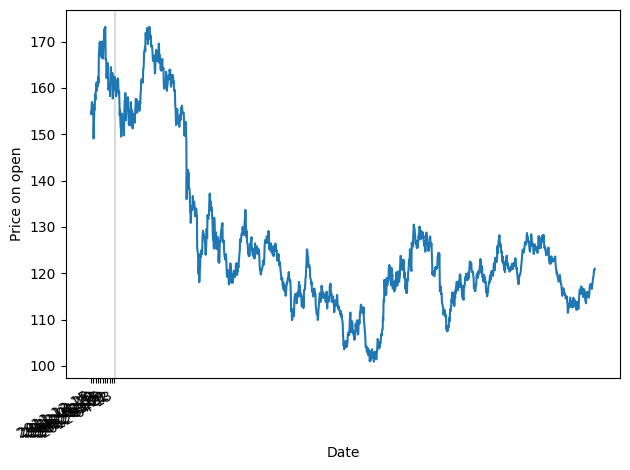

In [19]:
fig, ax = plt.subplots ()
ax.plot (df ['Date'], df ['Open'])
ax.set_xlabel ("Date")
ax.set_ylabel ('Price on open')
ax.axvspan (80, 83, color = '#808080', alpha = 0.2)

plt.xticks (np.arange (0, 81, 8))

fig.autofmt_xdate ()
plt.tight_layout ()